# Setup and Library Installation

In [1]:
# ----------- pip installs ----------- #
#!pip install pandas
#!pip install numpy
#!pip install seaborn
#!pip install matplotlib
!pip install germalemma stanza spacy nltk bertopic[visualization] sentence-transformers tf-keras --quiet
!python -m spacy download de_core_news_md
!pip install transformers --quiet
!pip install torch --quiet
!pip install --upgrade transformers
!pip install transformers datasets scikit-learn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.1/22.1 MB 62.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 82.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 78.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 91.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 40.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/

In [2]:
# ----------- imports ----------- #
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from germalemma import GermaLemma
import stanza
import random
from datasets import Dataset
from tqdm import tqdm
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import NaiveBayesClassifier, classify
import spacy
from IPython.display import display
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, classification_report
from sentence_transformers import SentenceTransformer
from transformers import TrainingArguments, Trainer
from transformers import (
    AutoTokenizer, BertForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback)
from transformers import BertTokenizer
from transformers import pipeline
from transformers import BertForSequenceClassification
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.representation import MaximalMarginalRelevance
from bertopic import BERTopic

In [3]:
#Set seed for reproducibility
random.seed(222)
np.random.seed(222)

In [4]:
#Access Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Speech Data

In [5]:
path_speech = "/content/drive/MyDrive/CBS/NLP/Final/Bundestag.csv" #Load speech data
path_meta = "/content/drive/MyDrive/CBS/NLP/Final/all_mps_meta 2.csv" #Load Metadata per speaker
df_speeches = pd.read_csv(path_speech)
df_meta = pd.read_csv(path_meta)

# Data Cleaning and Preprocessing

In [6]:
#Merge Datasets to get the gender information of the speaker in the speeches df
df = pd.merge(
    df_speeches,
    df_meta[['MPID', 'SexOrGender', 'Name', 'Born']],
    on='MPID',
    how='left')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5192475 entries, 0 to 5192474
Data columns (total 12 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   Period        int64 
 1   Session       int64 
 2   Date          object
 3   Chair         bool  
 4   Interjection  bool  
 5   MPID          int64 
 6   Party         object
 7   Constituency  object
 8   Speech        object
 9   SexOrGender   object
 10  Name          object
 11  Born          object
dtypes: bool(2), int64(3), object(7)
memory usage: 406.1+ MB


In [8]:
#Ensure 'Date' is in datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

In [9]:
#Create a unique entry ID based on SpeakerID and Date (assuming one speaker only speeks once per day)
df['SpeechID'] = df['MPID'].astype(str) + '_' + df['Date'].dt.strftime('%Y-%m-%d')

In [10]:
#Replace german with english gender words
df['SexOrGender'] = df['SexOrGender'].replace({
    'männlich': 'male',
    'weiblich': 'female'})

In [11]:
#Rename Gender Column
df = df.rename(columns={'SexOrGender': 'Gender'})

## Data Cleaning & Filtering

In [12]:
#Drop rows with missing MPID or undefined party affiliations
df = df.dropna(subset=['MPID'])
df = df[df['Party'] != '[]']

In [13]:
#Filter for the exact duration of the 19th legislative period
df = df[(df['Date'] >= '2017-10-24') & (df['Date'] <= '2021-10-26')]

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 482423 entries, 4602535 to 5173828
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Period        482423 non-null  int64         
 1   Session       482423 non-null  int64         
 2   Date          482423 non-null  datetime64[ns]
 3   Chair         482423 non-null  bool          
 4   Interjection  482423 non-null  bool          
 5   MPID          482423 non-null  int64         
 6   Party         482423 non-null  object        
 7   Constituency  120862 non-null  object        
 8   Speech        482423 non-null  object        
 9   Gender        297223 non-null  object        
 10  Name          297223 non-null  object        
 11  Born          297223 non-null  object        
 12  SpeechID      482423 non-null  object        
dtypes: bool(2), datetime64[ns](1), int64(3), object(7)
memory usage: 45.1+ MB


In [15]:
#Drop rows with missing values for "SexOrGender"
df = df.dropna(subset=['Gender'])

In [16]:
#Inspect different parties
df['Party'].value_counts()

,count
Party,
['fdp'],80604
['cdu'],77150
['spd'],45239
['die grünen'],36234
['afd'],31870
['linke/pds/sed'],24451
['fraktionslos'],1484
"['[""fraktionslos"" ""die partei""]']",128
"['[""afd"" ""fraktionslos""]']",57


We observed fragmentation in party labels - especially due to interjections or brief segments attributed to other parties during longer speeches. To ensure consistency and analytical relevance, we remove such fragmented cases and retain only the main parties with substantial speech representation. Additionally, we group CDU and CSU together, reflecting their frequent collaboration as a unified parliamentary bloc.

In [17]:
relevant_parties = ["['fdp']", "['cdu']", "['csu']", "['spd']","['die grünen']", "['afd']", "['linke/pds/sed']","['cdu', 'csu']"]

df = df[df['Party'].isin(relevant_parties)]

df['Party'] = df['Party'].replace({"['cdu']": "['cdu', 'csu']","['csu']": "['cdu', 'csu']"})

We decided to remove chair and interjection entries, as our analysis focuses exclusively on full speeches delivered by parliament members.

In [18]:
df = df[(df['Interjection'] == False) & (df['Chair'] == False)]

We noticed that individual speeches were split across multiple rows for the same MP on the same date. Therefore, we concatenate these fragments to ensure each row represents a full speech.

In [19]:
#Group by MP and Date, keeping one record per speaker per session day
df = df.groupby(['MPID', 'Date'], as_index=False).agg({
    'Speech': ' '.join,
    'Period': 'first',
    'Session': 'first',
    'Chair': 'first',
    'Party': 'first',
    'Constituency': 'first',
    'Gender': 'first',
    'Name': 'first',
    'Born': 'first'})

We also noticed that this did not entirely solve the issue. In some rare cases the speech is still a random snipped (probably an interjection was inbetween). We decide to drop those to only keep the beginning of a full speech.


In [20]:
#Count speeches where the first character is lowercase
lowercase_start_count = df['Speech'].str.strip().str.match(r'^[a-zäöüß]').sum()

print(f"Number of speeches starting with a lowercase letter: {lowercase_start_count}")

Number of speeches starting with a lowercase letter: 587


In [21]:
#Remove speeches starting with a lowercase letter
df = df[~df['Speech'].str.strip().str.match(r'^[a-zäöüß]')]

We also noticed that some speeches consisted of only a few words - often just interruptions, fragments, or unfinished phrases. Since our analysis focuses on complete and comparable speech units, we removed all entries with fewer than 200 words. Additionally, to ensure consistent input length for sentiment analysis and reduce noise from overly long speeches, we truncated all remaining speeches to 200 words. This approach follows practices such as Dahllöf (2012), mentioned in our paper.
 We also removed the first ten words of each speech to exclude introductory phrases and formalities, which are typically non-informative.

In [22]:
#Remove speeches with fewer than 200 words and truncate the rest
word_count = lambda x: len(str(x).split())
df = df[df['Speech'].apply(word_count) >= 200]
df['Speech'] = df['Speech'].apply(lambda x: ' '.join(str(x).split()[10:210]))

Furthermore, we noticed that some speeches contain procedural or audience reaction markers such as “Beifall der” / “Beifall von” (applause) and “Zuruf von” / “Zuruf der”(shout / interjection from), which are not part of the actual speech content. To avoid biasing the classifier with these artifacts, we remove all speeches containing such phrases.

In [23]:
#Remove reaction markers such as applause or shout (with Regex pattern to account for all cases)
pattern = r'(?i)\\b(Beifall|Zuruf)\\s*[,.:;\\-\\u2013]?\\s*(von|der|bei)\\b'
df = df[~df['Speech'].str.contains(pattern, na=False)]

We observed that some MPs gave a disproportionately high number of speeches, which could introduce speaker-specific bias into our analysis. To mitigate this, we calculated the upper whisker threshold using the boxplot rule (Q3 + 1.5 × IQR) and set a cutoff at 65 speeches. MPs with more than 65 speeches were limited to 65 randomly selected ones to ensure balanced representation across speakers.

In [24]:
#Count number of speeches per MPID
mpid_counts = df['MPID'].value_counts()

#Display top 10 MPs with the most speeches
print("Top 10 MPs by number ofy speeches:")
print(mpid_counts.head(10))

#Display bottom 10 MPs with the fewest speeches
print("\nBottom 10 MPs by number of speeches:")
print(mpid_counts.tail(10))

Top 10 MPs by number ofy speeches:
MPID
18753    229
19133    185
18718    179
19274    178
18787    166
19600    159
18767    149
19433    134
19873    131
18503    117
Name: count, dtype: int64

Bottom 10 MPs by number of speeches:
MPID
19991    1
19859    1
19338    1
19419    1
19552    1
19572    1
19199    1
19265    1
19155    1
19812    1
Name: count, dtype: int64


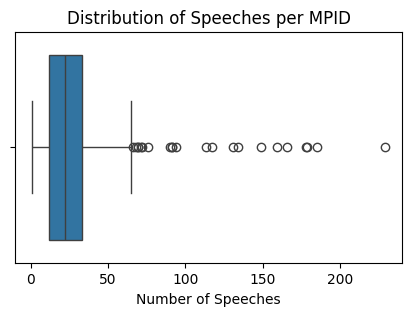

In [25]:
#Plot distribution of Speeches per MPID (SpeakerID)
plt.figure(figsize=(5, 3))
sns.boxplot(x=mpid_counts)

#Add labels and title
plt.xlabel("Number of Speeches")
plt.title("Distribution of Speeches per MPID")
plt.show()

In [26]:
#Calculate the first and third quartiles
Q1 = mpid_counts.quantile(0.25)
Q3 = mpid_counts.quantile(0.75)
IQR = Q3 - Q1

#Calculate the upper whisker value and set threshold
upper_whisker = Q3 + 1.5 * IQR
threshold = int(upper_whisker)
print(f"Upper whisker threshold (max speeches per MP to keep): {int(upper_whisker)}")

Upper whisker threshold (max speeches per MP to keep): 65


In [27]:
#Map the speech count to the dataframe
df['speech_count'] = df['MPID'].map(mpid_counts)

#Filter based on threshold
df_kept = df[df['speech_count'] <= threshold]
df_sampled = (
    df[df['speech_count'] > threshold]
    .groupby('MPID', group_keys=False)
    .apply(lambda x: x.sample(n=65, random_state=42)))

# Combine
df = pd.concat([df_kept, df_sampled], ignore_index=True)

<ipython-input-27-5f7a09b24fca>:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=65, random_state=42)))


In [28]:
#Check number of speeches per gender for imbalance
df['Gender'].value_counts()

,count
Gender,
male,10257
female,4252


We noticed a clear class imbalance with significantly more speeches held by male MPs, which may affect downstream classification performance.

To ensure fair training conditions for the classification model later, we balance the dataset across gender. Since male speeches dominate the corpus, we apply undersampling (4000 speeches per group) to avoid bias toward the majority class and enable better generalization across genders.

In [29]:
#Balance the dataset across gender
df = df[df['Gender'].isin(['male', 'female'])]
df = df.groupby('Gender', group_keys=False).apply(lambda x: x.sample(n=4000, random_state=222)).reset_index(drop=True)

<ipython-input-29-cdd8b9eb1a37>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Gender', group_keys=False).apply(lambda x: x.sample(n=4000, random_state=222)).reset_index(drop=True)


In [30]:
#Check final counts
print(df['Gender'].value_counts())

Gender
female    4000
male      4000
Name: count, dtype: int64


In [31]:
#Create a pivot table to show the count of speeches by party and gender
gender_party_table = df.groupby(['Party', 'Gender']).size().unstack(fill_value=0)
print(gender_party_table)

Gender             female  male
Party                          
['afd']               224   680
['cdu', 'csu']        639  1387
['die grünen']        955   304
['fdp']               522   575
['linke/pds/sed']     505   284
['spd']              1155   770


# Tokenization and Lemmatizing

In [32]:
#Load spaCy model for german language processing
nlp = spacy.load("de_core_news_md")
#Load package for preprocessing
nltk.download('punkt')
nltk.download('stopwords')
#Load german stopwords set
stop_words = set(stopwords.words('german'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [33]:
#Define and execture function to preprocess the speech column
def data_preprocess(text):
    doc = nlp(text)
    return " ".join([ #recombines cleaned, lemmetized tokens in single string
        token.lemma_.lower() for token in doc #lemmetization & conversion to lowercase
        if token.is_alpha and token.text.lower() not in stop_words]) #removes pre-defined stopwords

df['Speech_cleaned'] = df['Speech'].apply(data_preprocess) #return new column with cleaned speech

In [34]:
df.head()

,MPID,Date,Speech,Period,Session,Chair,Party,Constituency,Gender,Name,Born,speech_count,Speech_cleaned
0,19274,2020-11-26,Dass die wirtschaftlichen Hilfen jetzt auch im...,19,195,False,['fdp'],None,female,Renata Alt,27.08.1965 00:00,178,wirtschaftlich hilfe dezember notwendig der no...
1,19865,2020-09-17,heute über die Verlängerung des COVID-19-Insol...,19,176,False,['linke/pds/sed'],None,female,Gökay Akbulut,16.11.1982 00:00,25,heute verlängerung dezember ab märz jahr begin...
2,18753,2020-10-30,"eigenen Vorlieben designen kann, indem man sic...",19,187,False,['fdp'],None,female,Ulla Ihnen,06.01.1956 00:00,229,eigen vorliebe designen grösse deutsch bundest...
3,19673,2019-01-30,"Wir erkennen natürlich an, dass diese erhöht w...",19,76,False,['linke/pds/sed'],None,female,Nicole Gohlke,15.11.1975 00:00,29,erkennen natürlich erhöhen wohnpauschale euro ...
4,19931,2018-02-22,"dazu da, ihre Pflichten im Haus zu erfüllen . ...",19,14,False,['fdp'],None,female,Katrin Helling-Plahr,02.04.1986 00:00,27,pflicht haus erfüllen dringend notfäll dürfen ...


## Vectorization: BoW and TF-IDF

In [35]:
#Define BoW and TFIDF Vectorizer
bow_vectorizer = CountVectorizer(max_features=20)
tfidf_vectorizer = TfidfVectorizer(max_features=20)

#Apply on preprocessed column
bow_clean = bow_vectorizer.fit_transform(df['Speech_cleaned'])
tfidf_clean = tfidf_vectorizer.fit_transform(df['Speech_cleaned'])

print("Top 10 BoW Words (After Preprocessing):")
print(bow_vectorizer.get_feature_names_out())
print("\nTop 10 TF-IDF Words (After Preprocessing):")
print(tfidf_vectorizer.get_feature_names_out())

Top 10 BoW Words (After Preprocessing):
['bundestag' 'deutsch' 'deutschland' 'ganz' 'geben' 'gehen' 'gut' 'herr'
 'heute' 'ja' 'jahr' 'kollege' 'land' 'mehr' 'mensch' 'müssen' 'sagen'
 'schon' 'vieler' 'werden']

Top 10 TF-IDF Words (After Preprocessing):
['bundestag' 'deutsch' 'deutschland' 'ganz' 'geben' 'gehen' 'gut' 'herr'
 'heute' 'ja' 'jahr' 'kollege' 'land' 'mehr' 'mensch' 'müssen' 'sagen'
 'schon' 'vieler' 'werden']


# Topic Modeling

Summary:
1. LDA Topic Modeling
2. BERT Topic Modelling

First different topic modeling techniques are tried before the difference between genders is analyzed.

## 1. LDA Topic Modelling overall topics

In [36]:
#Vectorize speeches and removing tokens that are too common (appearing less than 50%) and tokens that are too rare (less than 8 appearances in documents so less than 0.1%)
vectorizer = CountVectorizer(
    min_df=8,
    max_df=0.5)
doc_term_matrix = vectorizer.fit_transform(df['Speech_cleaned'])

In [37]:
#Check number of unique tokens after filtering
tokens_post_feature = len(vectorizer.get_feature_names_out())
print(f"Total number of unique tokens after removing too common or rare tokens: {tokens_post_feature}")

Total number of unique tokens after removing too common or rare tokens: 7895


In [38]:
#Count number of non-zero tokens in each document
token_counts_after_filtering = (doc_term_matrix > 0).sum(axis=1)
token_counts_after_filtering = np.array(token_counts_after_filtering).flatten()
print("Average document length (after filtering):", token_counts_after_filtering.mean())
print("Median:", np.median(token_counts_after_filtering))
print("Min:", token_counts_after_filtering.min())
print("Max:", token_counts_after_filtering.max())

Average document length (after filtering): 69.047875
Median: 69.0
Min: 24
Max: 95


After several iterations with varying number of topics between 10 and 45, we found that 20 topics is most suitable for our baseline LDA.

In [39]:
#Define number of topics
num_topics = 20

#Train the LDA model on your filtered BoW matrix
lda_model = LatentDirichletAllocation(
    n_components=num_topics,
    max_iter=10,
    learning_method='batch',
    random_state=42)
lda_model.fit(doc_term_matrix)

LatentDirichletAllocation(n_components=20, random_state=42)

### Get Top 20 Topics (LDA)

In [40]:
#Get vocabulary words
feature_names = vectorizer.get_feature_names_out()

# Assign dominant topic per document
doc_topic_dist = lda_model.transform(doc_term_matrix)
dominant_topics = np.argmax(doc_topic_dist, axis=1)

# Count number of speeches per topic
topic_counts = Counter(dominant_topics)

# Print top words + number of speeches for each topic
for idx, topic in enumerate(lda_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-8:-1]]
    count = topic_counts.get(idx, 0)  # default to 0 if no documents for topic
    print(f"Topic #{idx + 1} ({count} speeches): {' '.join(top_words)}")

Topic #1 (835 speeches): werden gesetz geben gesetzentwurf bundesregierung schon gehen
Topic #2 (131 speeches): deutschland land geben israel menschenrecht staat china
Topic #3 (518 speeches): bundestag deutsch wahlperiode sitzung berlin sagen donnerstag
Topic #4 (178 speeches): herr dame schon vieler geben stehen immer
Topic #5 (459 speeches): mensch frau leben vieler land krise pandemie
Topic #6 (225 speeches): gesetz geben gesetzlich jahr patient mehr herr
Topic #7 (364 speeches): deutsch berlin bundestag gut wahlperiode sitzung deutschland
Topic #8 (450 speeches): europäisch europa deutschland union eu prozent jahr
Topic #9 (335 speeches): kollege wichtig müssen mensch debatte kollegin demokratie
Topic #10 (435 speeches): frage herr ja jahr haushalt sagen geld
Topic #11 (224 speeches): herr deutsch bundestag fraktion geben bundesregierung frage
Topic #12 (144 speeches): frau geben jahr vieler frage bundesregierung gehen
Topic #13 (197 speeches): euro milliarde million jahr geld unt

In [41]:
#Get vocabulary words
feature_names = vectorizer.get_feature_names_out()

#Assign dominant topic per document
doc_topic_dist = lda_model.transform(doc_term_matrix)
dominant_topics = np.argmax(doc_topic_dist, axis=1)

#Count speeches per topic
topic_counts = Counter(dominant_topics)

#Get top words and speech count per topic
topics_info = []

for idx, topic in enumerate(lda_model.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-8:-1]]
    count = topic_counts.get(idx, 0)
    topics_info.append((idx + 1, ' '.join(top_words), count))

#Sort by number of speeches descending
topics_info_sorted = sorted(topics_info, key=lambda x: x[2], reverse=True)

for tid, words, count in topics_info_sorted:
    topic_label = f"Topic #{tid:02}"  # ensures two-digit formatting like Topic #01, #19
    print(f"{topic_label:<10} {words:<70} {count}")

Topic #19  antrag kollege sagen kollegin herr schon mal                           1011
Topic #17  gut mehr mensch müssen brauchen heute wichtig                          875
Topic #01  werden gesetz geben gesetzentwurf bundesregierung schon gehen          835
Topic #03  bundestag deutsch wahlperiode sitzung berlin sagen donnerstag          518
Topic #15  bundeswehr soldat einsatz werden bundesregierung jahr deutsch          493
Topic #05  mensch frau leben vieler land krise pandemie                           459
Topic #08  europäisch europa deutschland union eu prozent jahr                    450
Topic #10  frage herr ja jahr haushalt sagen geld                                 435
Topic #07  deutsch berlin bundestag gut wahlperiode sitzung deutschland           364
Topic #09  kollege wichtig müssen mensch debatte kollegin demokratie              335
Topic #18  landwirtschaft problem herr müssen deutsch sagen gehen                 298
Topic #14  werden jahr deutschland mensch deutsch heu

Get Overview over how often male/female speakers spoke about top topics

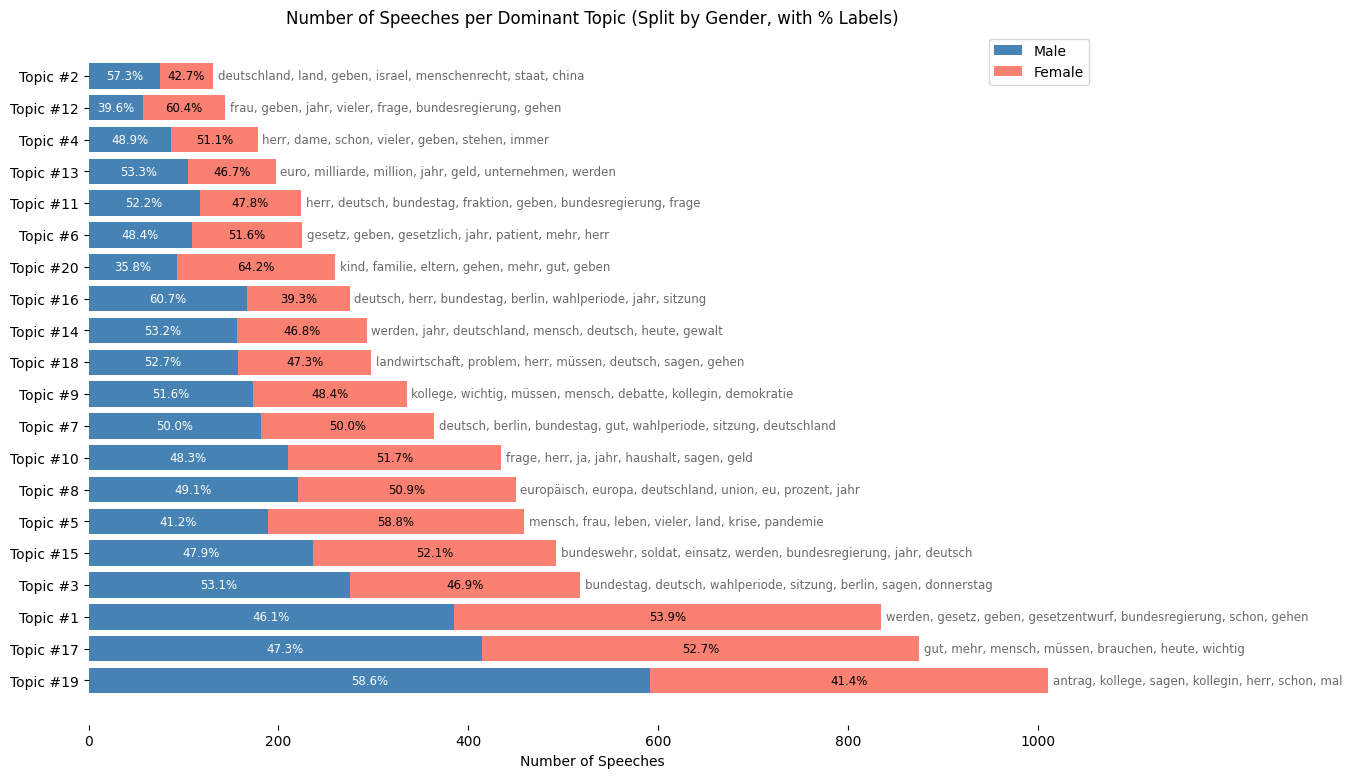

In [42]:
#Get top 7 words per topic
topic_keywords = [
    ", ".join([feature_names[i] for i in topic.argsort()[:-8:-1]])
    for topic in lda_model.components_
]

#Map gender to numeric
gender = df['Gender'].reset_index(drop=True)
is_female = (gender == 'female').astype(int)
is_male = (gender == 'male').astype(int)

#Count gender per topic
male_counts = np.zeros(num_topics)
female_counts = np.zeros(num_topics)
for i in range(num_topics):
    mask = dominant_topics == i
    male_counts[i] = is_male[mask].sum()
    female_counts[i] = is_female[mask].sum()

total_counts = male_counts + female_counts

#Sort topics by total count
sorted_indices = np.argsort(total_counts)[::-1]
male_sorted = male_counts[sorted_indices]
female_sorted = female_counts[sorted_indices]
keywords_sorted = [topic_keywords[i] for i in sorted_indices]
total_sorted = male_sorted + female_sorted

#Compute % labels
percent_male = (male_sorted / total_sorted * 100).round(1)
percent_female = (female_sorted / total_sorted * 100).round(1)

#Plot
y_pos = np.arange(num_topics)
plt.figure(figsize=(13, 9))
bars_male = plt.barh(y_pos, male_sorted, color='steelblue', label='Male')
bars_female = plt.barh(y_pos, female_sorted, left=male_sorted, color='salmon', label='Female')

#Add topic words and % labels
for i in range(num_topics):
    total = total_sorted[i]
    topic_label = keywords_sorted[i]
    male_pct = percent_male[i]
    female_pct = percent_female[i]

    #Add topic keywords
    plt.text(total + 5, i, topic_label, va='center', fontsize=8.5, color='dimgray')

    #Add percentage labels on bars
    plt.text(male_sorted[i] / 2, i, f"{male_pct}%", va='center', ha='center', fontsize=8.5, color='white')
    plt.text(male_sorted[i] + female_sorted[i] / 2, i, f"{female_pct}%", va='center', ha='center', fontsize=8.5, color='black')

plt.yticks(y_pos, [f"Topic #{i+1}" for i in sorted_indices])
plt.xlabel("Number of Speeches")
plt.title("Number of Speeches per Dominant Topic (Split by Gender, with % Labels)")
plt.legend()
for spine in ['top', 'right', 'left', 'bottom']:
    plt.gca().spines[spine].set_visible(False)
plt.show()

## 2. BERT Topic Modelling

On the first BERT iteration, we used the standard configurations for all parts of the BERTopic (Embeddings, Dimensionality Reduction, Clustering, Vectorizers, c-TF-IDF, Representation model). In contrast to LDA, we applied BERTopic on the original Speech column (instead of on the preprocessed speech).

In [43]:
#Use unprocessed speech column because BERTopic does not require preprocessed texts
#Convert speech column into list of text
texts = df["Speech"].dropna().tolist()

#Load German-compatible embedding model to transform text into embeddings
embedding_model = SentenceTransformer("distiluse-base-multilingual-cased-v2")

#Define UMDAP (dimensionality reduction) and HDBSCAN (clustering) models with standard configurations
umap_model = UMAP(n_neighbors=15, min_dist=0.1, n_components=5, metric='cosine', random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean', prediction_data=True)

#Initialize countvectorizer but with stopwords (because we are not using preprocessed Speech column) stopwords from nltk were downloaded before
german_stopwords = stopwords.words("german")
vectorizer_model = CountVectorizer(stop_words=german_stopwords)

#intializing cfidf model
cfidf_model = ClassTfidfTransformer()
#Bringing elements together to intialize BERTopic model
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    ctfidf_model=cfidf_model,
    language="german")

modules.json:   0%|          | 0.00/341 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/2.46k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/610 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/539M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/531 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


config.json:   0%|          | 0.00/114 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.58M [00:00<?, ?B/s]

In [44]:
#Fit and transforming model with texts list of Speech column
topics, probs = topic_model.fit_transform(texts)

#Add to DataFrame
df["Topic"] = topics
df["Topic_Probability"] = probs

In [45]:
#Save model
topic_model.save("bertopic_model_german")

2025-05-28 11:06:17,015 - BERTopic - WARNING: When you use `pickle` to save/load a BERTopic model,please make sure that the environments in which you saveand load the model are **exactly** the same. The version of BERTopic,its dependencies, and python need to remain the same.


In [46]:
#Save results to csv
df.to_csv("df_with_topics_baseline.csv", index=False)

In [47]:
#Visualize topic results to inspect potential overlaps
topic_model.visualize_topics()

We can see that the initial BERTopic model performed quite well in creating sensible topics that can be interpreted well. However, based on the intertopic distance map, we see that some topics overlap. At the same time, the majority of speeches are assigned to -1 (meaning they constitute outliers). We try to fine tune the model in the next iteration to decrease topic overlaps while trying to reduce outliers.

## Finetuning BERTopic to see effects of changes
The following changes were implemented based on observation of first model:
- increasing n_neighbors to have larger topics and merge topics (looking at the different topics, they are quite specific)
- decreasing min_dist to have fewer outliers and prevent topic overlaps
- decreasing min cluster size (many outliers so allowing smaller clusters)
- add marginal relevance (more diverse keywords to describe topics)

In [48]:
#UMAP: Allow closer neighbors --> fewer outliers
umap_model_2 = UMAP(
    n_neighbors=25,
    min_dist=0.05,
    n_components=5,
    metric='cosine',
    random_state=42)

#HDBSCAN: Smaller clusters --> fewer unclustered docs
hdbscan_model_2 = HDBSCAN(
    min_cluster_size=10,
    metric='euclidean',
    prediction_data=True)
#Representation model: Diverse and interpretable topic words
representation_model = MaximalMarginalRelevance(diversity=0.7)

#Fine-tuned BERTopic model
topic_model_2 = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model_2,
    hdbscan_model=hdbscan_model_2,
    vectorizer_model=vectorizer_model,
    ctfidf_model=cfidf_model,
    representation_model=representation_model,
    language="german")

#Fit the model
topics2, probs2 = topic_model_2.fit_transform(texts)

In [49]:
df["Topic_2"] = topics2
df["Topic_Probability_2"] = probs2

In [50]:
topic_model_2.visualize_topics()

In [51]:
#Visualize top 10 reduced topics as a bar chart
topic_model_2.visualize_barchart(top_n_topics=10)

In [52]:
#Count speeches per topic
topic_counts_2 = df['Topic_2'].value_counts().sort_index()

#Get topic names from your model
topic_names_2 = topic_model_2.get_topic_info().set_index("Topic")["Name"]

#Create a combined table
topic_table_2 = pd.DataFrame({
    "Topic ID": topic_counts_2.index,
    "Topic Name": topic_counts_2.index.map(topic_names_2),
    "Number of Speeches": topic_counts_2.values
})
print(topic_table_2.to_markdown(index=False))

|   Topic ID | Topic Name                                                                          |   Number of Speeches |
|-----------:|:------------------------------------------------------------------------------------|---------------------:|
|         -1 | -1_heute_mehr_deutschland_19                                                        |                 3417 |
|          0 | 0_heute_bundesverfassungsgericht_geht_urteil                                        |                  252 |
|          1 | 1_kind_familie_euro_gesetz                                                          |                  249 |
|          2 | 2_debatte_vielleicht_dank_heute                                                     |                  226 |
|          3 | 3_menschen_impfen_covid_ja                                                          |                  221 |
|          4 | 4_ernährung_mehr_agrarpolitik_wolf                                                  |                  201 |
|       

UPDATE Compared to BERTopic 1, the changes resulted in more topics; some of which not clearly understandable such as XXX, or XXX. There are 300 less outliers compared to the first model initialization (belonging to topic -1) but the results do not seem to make as much sense. So we go back to the first BERTopic and reduce number of topics to 30.

In [53]:
#Drop columns for cleaner structure
df = df.drop(columns=["Topic", "Topic_Probability", "Topic_2", "Topic_Probability_2"])

## Final try: Intial BERTopic with reduced topics

In [54]:
#Load the saved BERTopic model
topic_model = BERTopic.load("bertopic_model_german")

In [55]:
#Use intial Bertopic but reducing topics to 30
topic_model_3 = topic_model.reduce_topics(texts, nr_topics=30)
topics_reduced, probs_reduced = topic_model_3.transform(texts)
df["Topic_Reduced"] = topics_reduced
df["Topic_Probability_Reduced"] = probs_reduced

In [56]:
topic_model_3.visualize_topics()

In [57]:
#Visualize top 10 reduced topics as a bar chart
topic_model_3.visualize_barchart(top_n_topics=10)

In [58]:
#Count speeches per reduced topic
topic_counts_3 = df['Topic_Reduced'].value_counts().sort_index()

#Get topic names from the reduced topic model
topic_names_3 = topic_model_3.get_topic_info().set_index("Topic")["Name"]

#Create a combined table
topic_table_reduced_3 = pd.DataFrame({
    "Topic ID": topic_counts_3.index,
    "Topic Name": topic_counts_3.index.map(topic_names_3),
    "Number of Speeches": topic_counts_3.values
})

#Display nicely
print(topic_table_reduced_3.to_markdown(index=False))

|   Topic ID | Topic Name                                                     |   Number of Speeches |
|-----------:|:---------------------------------------------------------------|---------------------:|
|         -1 | -1_menschen_heute_bundestag_ja                                 |                 3294 |
|          0 | 0_co2_klimaschutz_müssen_deutschland                           |                  796 |
|          1 | 1_schon_antrag_ja_bundestag                                    |                  697 |
|          2 | 2_menschen_müssen_pandemie_pflege                              |                  487 |
|          3 | 3_kinder_familien_eltern_bildung                               |                  386 |
|          4 | 4_europa_eu_europäischen_union                                 |                  380 |
|          5 | 5_bundeswehr_soldaten_mali_soldatinnen                         |                  259 |
|          6 | 6_digitalisierung_digitale_digitalen_daten                

As these seem 30 well distinguished topics that make sense, we move on to the gender analysis.

In [59]:
#Count speeches by topic and gender
topic_gender_counts = df.groupby(["Topic_Reduced", "Gender"]).size().unstack(fill_value=0)

#Add totals and sort
topic_gender_counts["Total"] = topic_gender_counts.sum(axis=1)
topic_gender_counts_sorted = topic_gender_counts.sort_values("Total", ascending=False)

#Calculate percentages
topic_gender_counts["% female"] = topic_gender_counts["female"] / topic_gender_counts["Total"] * 100
topic_gender_counts["% male"] = topic_gender_counts["male"] / topic_gender_counts["Total"] * 100

First, we display the top 10 most frequent topics

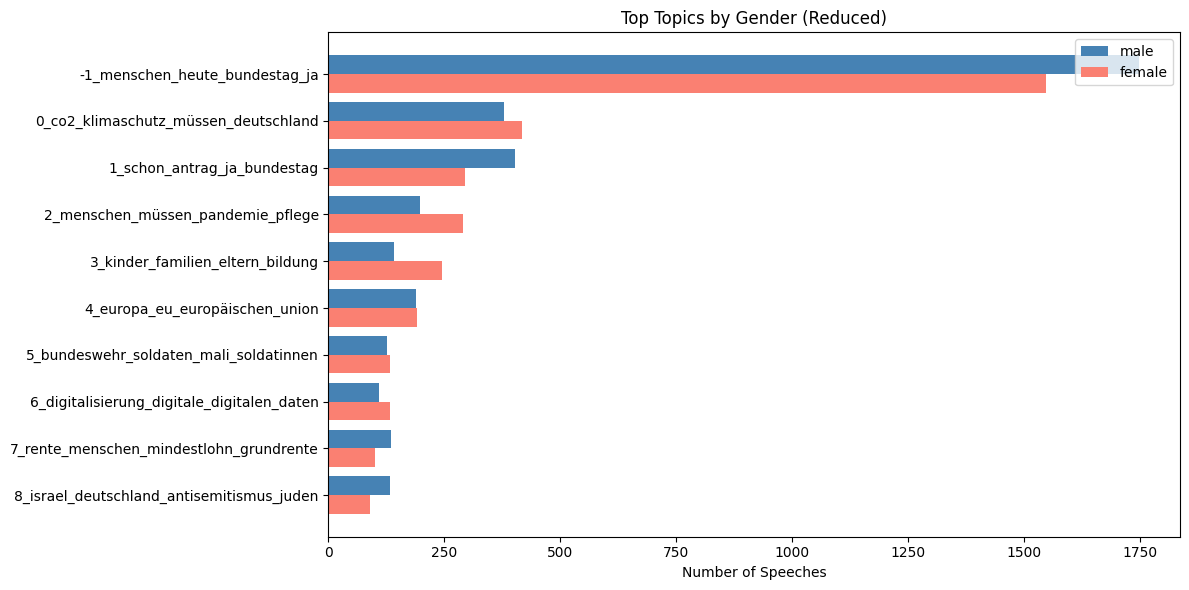

In [60]:
#Top 10 topics
top_10 = topic_gender_counts_sorted.head(10)
counts = top_10[["male", "female"]]
topics = top_10.index

#Get topic labels (first 3 words only)
topic_info = topic_model_3.get_topic_info()
topic_labels = {row["Topic"]: row["Name"] for _, row in topic_info.iterrows()}
keywords = [" ".join(topic_labels[t].split()[:]) for t in topics]

#y-axis positions
y = np.arange(len(topics))
height = 0.4

#Plot
plt.figure(figsize=(12, 6))
plt.barh(y - height/2, counts["male"], height, label="male", color='steelblue')
plt.barh(y + height/2, counts["female"], height, label="female", color='salmon')

#Labels
plt.yticks(y, keywords)
plt.xlabel("Number of Speeches")
plt.title("Top Topics by Gender (Reduced)")
plt.legend(loc='upper right')
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

In [61]:
#Truncate topic names to first 3 words (or full label if preferred)
def truncate_label(label, num_words=3):
    return " ".join(label.split()[:num_words])

#Map topic IDs to their full names
topic_info = topic_model_3.get_topic_info()
id_to_label = dict(zip(topic_info.Topic, topic_info.Name))

#Add readable labels to topic_gender_counts
gender_percent_with_counts = topic_gender_counts[["% female", "% male", "Total"]].copy()
gender_percent_with_counts.index = gender_percent_with_counts.index.map(
    lambda t: truncate_label(id_to_label.get(t, f"Topic {t}")))

# Filter out topics with fewer than 25 speeches
gender_percent_with_counts = gender_percent_with_counts[gender_percent_with_counts["Total"] >= 25]

# Sort by % gender
most_female_topics = gender_percent_with_counts.sort_values("% female", ascending=False).head(5)
most_male_topics = gender_percent_with_counts.sort_values("% male", ascending=False).head(5)

#Display
print("Top 5 Topics by % Female Speeches:\n")
display(
    most_female_topics.style
    .set_caption("Most Female-Associated Topics")
    .format({"% female": "{:.1f}%", "% male": "{:.1f}%", "Total": "{:.0f}"}))

print("\nTop 5 Topics by % Male Speeches:\n")
display(
    most_male_topics.style
    .set_caption("Most Male-Associated Topics")
    .format({"% female": "{:.1f}%", "% male": "{:.1f}%", "Total": "{:.0f}"}))

Top 5 Topics by % Female Speeches:



Gender,% female,% male,Total
Topic_Reduced,,,
9_frauen_gewalt_männer_gleichberechtigung,84.0%,16.0%,162
20_ärztinnen_219a_frauen_leben,79.3%,20.7%,29
3_kinder_familien_eltern_bildung,63.5%,36.5%,386
2_menschen_müssen_pandemie_pflege,59.3%,40.7%,487
14_demokratie_medien_demokratischen_gerade,57.1%,42.9%,63



Top 5 Topics by % Male Speeches:



Gender,% female,% male,Total
Topic_Reduced,,,
18_griechenland_griechischen_griechen_iwf,31.2%,68.8%,32
8_israel_deutschland_antisemitismus_juden,40.5%,59.5%,222
16_wasser_prozent_weltmeere_trinkwasser,41.0%,59.0%,39
1_schon_antrag_ja_bundestag,42.3%,57.7%,697
17_tourismus_tourismusstrategie_branche_tourismuswirtschaft,42.9%,57.1%,35


## BERTopic on gender filtered dataset separately

For Males

In [62]:
df_male = df[df['Gender'] == 'male']
df_female = df[df['Gender'] == 'female']

In [63]:
#Extract the Speech column as a list for male and female dataframes
texts_male = df_male["Speech"].dropna().tolist()
texts_female = df_female["Speech"].dropna().tolist()

In [64]:
#Common model components
embedding_model = SentenceTransformer("distiluse-base-multilingual-cased-v2")
umap_model = UMAP(n_neighbors=15, min_dist=0.1, n_components=5, metric="cosine", random_state=42)
hdbscan_model = HDBSCAN(min_cluster_size=15, metric="euclidean", prediction_data=True)
vectorizer_model = CountVectorizer(stop_words=german_stopwords)
ctfidf_model = ClassTfidfTransformer()

In [65]:
#male topic modelling
topic_model_male = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    ctfidf_model=ctfidf_model,
    language="german"
)
topics_male, probs_male = topic_model_male.fit_transform(texts_male)

In [66]:
#Reduce topics for male
topic_model_male_reduced = topic_model_male.reduce_topics(texts_male, nr_topics=30)
topics_male_reduced, probs_male_reduced = topic_model_male_reduced.transform(texts_male)

#assign to df
df_male["Topicd"] = topics_male_reduced
df_male["Topic_Probability"] = probs_male_reduced

Female

In [67]:
#female topic modelling
topic_model_female = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    ctfidf_model=ctfidf_model,
    language="german")
topics_female, probs_female = topic_model_female.fit_transform(texts_female)

#Reduce topics for female
topic_model_female_reduced = topic_model_female.reduce_topics(texts_female, nr_topics=30)
topics_female_reduced, probs_female_reduced = topic_model_female_reduced.transform(texts_female)

#Assign to df
df_female["Topic"] = topics_female_reduced
df_female["Topic_Probability"] = probs_female_reduced

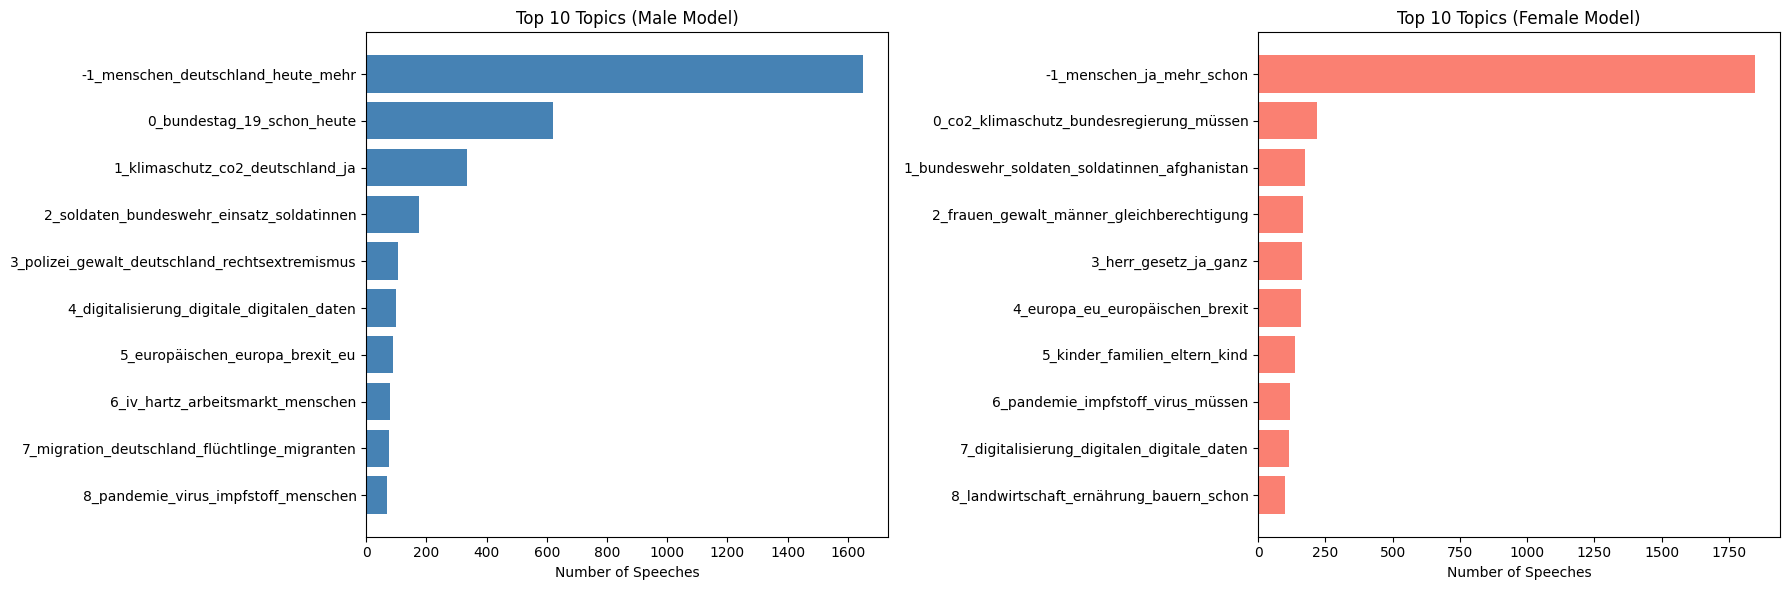

In [68]:
#get topic counts for each model
topic_counts_male = df_male["Topicd"].value_counts().head(10)
topic_counts_female = df_female["Topic"].value_counts().head(10)

#get topic keywords from each model
topic_labels_male = {row["Topic"]: row["Name"] for _, row in topic_model_male.get_topic_info().iterrows()}
topic_labels_female = {row["Topic"]: row["Name"] for _, row in topic_model_female.get_topic_info().iterrows()}

#get top 10 keywords for each
keywords_male = [topic_labels_male[t] for t in topic_counts_male.index]
keywords_female = [topic_labels_female[t] for t in topic_counts_female.index]

#counts
male_counts = topic_counts_male.values
female_counts = topic_counts_female.values
#plot
plt.figure(figsize=(18, 6))
plt.subplot(1, 2, 1)
plt.barh(keywords_male, male_counts, color='steelblue')
plt.xlabel("Number of Speeches")
plt.title("Top 10 Topics (Male Model)")
plt.gca().invert_yaxis()
plt.subplot(1, 2, 2)
plt.barh(keywords_female, female_counts, color='salmon')
plt.xlabel("Number of Speeches")
plt.title("Top 10 Topics (Female Model)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Sentiment Analysis

3 Typical ways:

1. Lexicon-Based Approaches (Good for interpretability, rule-based baselines)
2. Classical ML-Based Approaches (TF-IDF + Logistic Regression / SVM / Random Forest) --> only works whe labeled data is available. Will be excluded here. Clustering works but will not be done (more for the structure).
3. Deep Learning / Transformer Models (GermanBERT:Great zero-shot or fine-tuned model for classification; LLaMA/GPT
Can be prompted or fine-tuned for retrieval or zero-shot classification)

## 1 Lexicon Based: Sentiment Analysis using BAWL (German Dictionary)

Source BAWL Lexicon: https://www.scenegrammarlab.com/databases/bawl-r-database/

In [69]:
#Load downloaded lexicon
path_bawl ='/content/drive/MyDrive/CBS/NLP/Final/BAWL-R.xlsx'
df_BAWL = pd.read_excel(path_bawl)

In [70]:
df_BAWL.describe()

,EMO_MEAN,EMO_STD,AROUSAL_MEAN,AROUSAL_STD,IMAGE_MEAN,IMAGE_STD,LETTERS,PHONEMES,SYLLABLES,Ftot/1MIL,N,FN,HFN,FHFN,BIGmean(TOKEN),ACCENT
count,2902.000000,2902.000000,2902.000000,2902.000000,2902.000000,2902.000000,2902.000000,2899.000000,2902.000000,2902.000000,2902.000000,2902.000000,2902.000000,2902.000000,2902.000000,2899.000000
mean,0.062612,0.967384,2.757193,1.044048,4.170111,1.419655,6.433494,5.694722,2.155755,53.137031,1.616127,254.788604,0.566506,216.667074,229580.420588,1.339427
std,1.251953,0.293269,0.681202,0.191659,1.381943,0.366717,1.519342,1.476154,0.667252,152.508853,2.305395,2735.931392,1.186019,2262.674860,155674.981170,0.622780
min,-3.000000,0.000000,1.105263,0.315302,1.222222,0.325813,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8024.500000,1.000000
25%,-0.941176,0.767772,2.235294,0.911910,3.000000,1.183003,5.000000,5.000000,2.000000,2.670000,0.000000,0.000000,0.000000,0.000000,96832.562500,1.000000
50%,0.200000,0.950000,2.666667,1.043185,4.111111,1.455494,6.000000,6.000000,2.000000,11.333333,1.000000,1.000000,0.000000,0.000000,198342.138889,1.000000
75%,1.000000,1.154701,3.236071,1.179185,5.363636,1.688387,8.000000,7.000000,3.000000,48.666667,2.000000,47.750000,1.000000,12.670000,336360.550000,2.000000
max,2.900000,2.054805,4.705882,1.652572,6.888889,2.595367,10.000000,10.000000,6.000000,4190.333333,18.000000,130233.000000,11.000000,104092.000000,839507.333333,5.000000


In [71]:
#Rename relevant columns for consistency
df_BAWL = df_BAWL.rename(columns={
    'Wort': 'word',
    'EMO_MEAN': 'valence',
    'AROUSAL_MEAN': 'arousal',
    'IMAGE_MEAN': 'imageability'
})

To ensure comparability with the BERT-based sentiment scores presented below, the BAWL sentiment dimensions are rescaled to the range [−1, 1] using min-max normalization

In [72]:
# List of columns to scale
columns_to_scale = ['valence', 'arousal', 'imageability']

# Apply transformation to scale between -1 and 1
for col in columns_to_scale:
    min_val = df_BAWL[col].min()
    max_val = df_BAWL[col].max()
    df_BAWL[col] = 2 * (df_BAWL[col] - min_val) / (max_val - min_val) - 1

#Check if it it worked
df_BAWL[['WORD', 'valence', 'arousal', 'imageability']].head(10)

,WORD,valence,arousal,imageability
0,AAL,-0.152542,-0.291406,0.882353
1,AAS,-0.694915,-0.152193,0.490196
2,ABART,-0.525424,0.206745,-0.607843
3,ABBAU,-0.322034,0.052451,-0.645276
4,ABBAUEN,-0.254237,-0.444540,-0.136078
5,ABBILD,-0.050847,-0.444540,-0.098039
6,ABBRUCH,-0.220339,-0.000450,-0.450980
7,ABDANKEN,-0.118644,-0.132703,-0.489020
8,ABDRUCK,-0.016949,-0.372313,0.254902
9,ABEND,0.576271,-0.595586,0.140820


In [73]:
df_BAWL['valence'].max()

1.0

In [74]:
df_BAWL

,WORD,WORD_LOWER,WORD_CLASS,valence,EMO_STD,arousal,AROUSAL_STD,imageability,IMAGE_STD,LETTERS,PHONEMES,SYLLABLES,Ftot/1MIL,N,FN,HFN,FHFN,BIGmean(TOKEN),ACCENT
0,AAL,aal,N,-0.152542,0.707107,-0.291406,1.244033,0.882353,0.726483,3,2.0,1,13.333333,6,3182.00,3,3175.17,83677.500000,1.0
1,AAS,aas,N,-0.694915,1.100505,-0.152193,1.422460,0.490196,0.881917,3,2.0,1,1.000000,6,10568.83,5,10568.50,30120.500000,1.0
2,ABART,abart,N,-0.525424,0.699206,0.206745,1.017815,-0.607843,1.322876,5,5.0,2,1.166667,2,3.00,1,2.33,80270.000000,1.0
3,ABBAU,abbau,N,-0.322034,1.169795,0.052451,1.297771,-0.645276,1.231794,5,4.0,2,14.500000,1,6.83,0,0.00,94054.750000,1.0
4,ABBAUEN,abbauen,V,-0.254237,0.920000,-0.444540,1.242521,-0.136078,1.580000,7,6.0,3,15.500000,3,51.00,1,38.00,238806.333333,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2897,ZWIEBEL,zwiebel,N,-0.230508,1.120000,-0.075305,1.270000,0.668627,1.170000,7,6.0,2,12.830000,0,0.00,0,0.00,165840.666667,1.0
2898,ZWINGEN,zwingen,V,-0.690927,0.965076,0.515334,0.857493,-0.196078,1.702939,7,6.0,2,111.333333,4,5.33,0,0.00,374029.333333,1.0
2899,ZWIST,zwist,N,-0.423729,0.483046,0.524592,0.812728,-0.019608,1.322876,5,5.0,1,1.000000,1,0.67,0,0.00,126963.750000,1.0
2900,ZYLINDER,zylinder,N,-0.044068,0.730000,-0.425245,1.040000,0.396863,1.620000,8,8.0,3,4.330000,0,0.00,0,0.00,498122.714286,2.0


In [75]:
#Create a dictionary for fast lookup
bawl_dict = df_BAWL.set_index('WORD_LOWER')[['valence', 'arousal', 'imageability']].dropna().to_dict(orient='index')

In [76]:
#Define function to calculate valence / arousal/ imageability per speech by summing up
def compute_bawl_vai(text, lexicon):
    if not isinstance(text, str) or text.strip() == "":
        return pd.Series([None, None, None, 0])

    tokens = text.split()

    valence_sum = 0
    arousal_sum = 0
    image_sum = 0
    count = 0

    for token in tokens:
        if token in lexicon:
            valence_sum += lexicon[token]['valence']
            arousal_sum += lexicon[token]['arousal']
            image_sum += lexicon[token]['imageability']
            count += 1

    if count == 0:
        return pd.Series([None, None, None, 0])

    return pd.Series([
        valence_sum / count,
        arousal_sum / count,
        image_sum / count,
        count
    ])

In [77]:
#Apply function
df[['Valence', 'Arousal', 'Imageability', 'BAWL_Hits']] = df['Speech_cleaned'].apply(
    lambda x: compute_bawl_vai(x, bawl_dict))

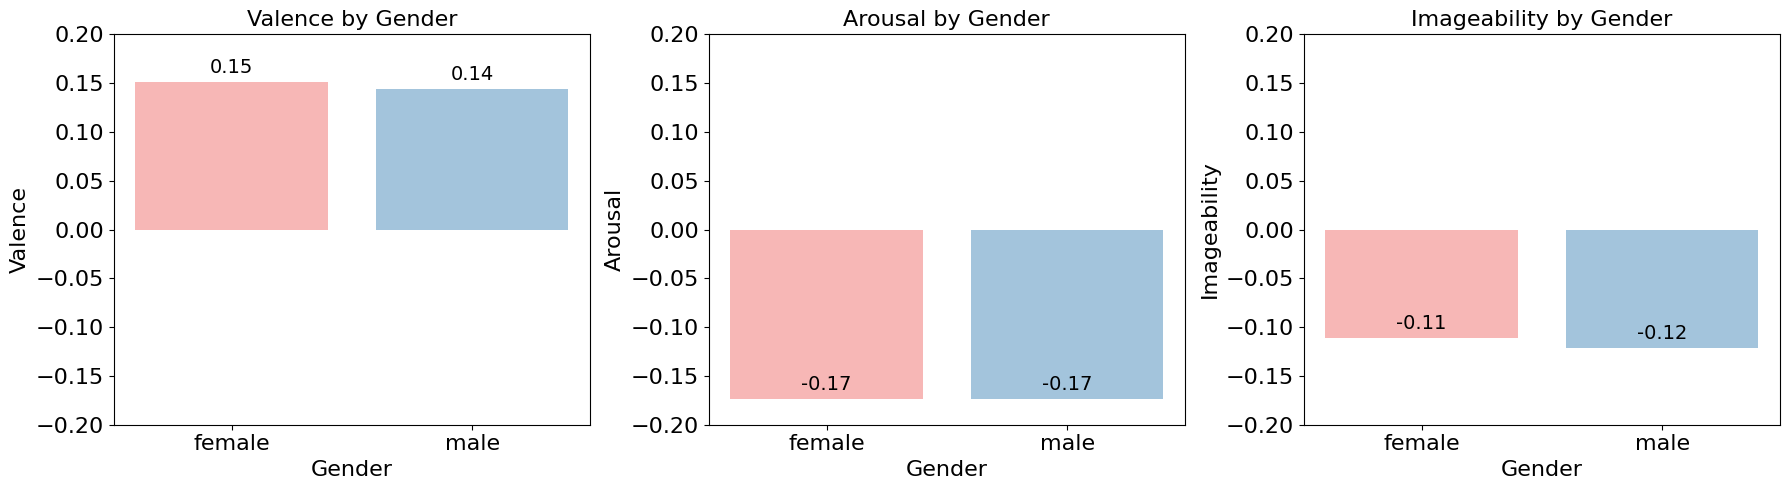

In [78]:
#Group by gender and compute mean/std
agg = df.groupby('Gender')[['Valence', 'Arousal', 'Imageability']].agg(['mean', 'std'])
agg.columns = ['_'.join(col) for col in agg.columns]
agg = agg.reset_index()

#Define gender-specific colors
gender_colors = {'female': '#F7B7B6', 'male': '#A3C4DC'}

#Plot
features = ['Valence', 'Arousal', 'Imageability']
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for ax, feat in zip(axes, features):
    x = agg['Gender']
    y = agg[f'{feat}_mean']
    colors = [gender_colors.get(g, 'grey') for g in x]

    #Plot bars
    bars = ax.bar(x=x, height=y, color=colors)

    #Add data labels directly above bars (consistent formatting)
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.005,
            f'{height:.2f}',
            ha='center',
            va='bottom',
            fontsize=14
        )

    ax.set_title(f'{feat} by Gender', fontsize = 16)
    ax.set_ylabel(feat, fontsize=16)
    ax.set_xlabel('Gender', fontsize=16)
    ax.tick_params(axis='x', rotation=0, labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

    # Set same y-axis scale for comparability
    ax.set_ylim(-0.2, 0.2)

plt.tight_layout()
plt.show()

We observe that across all three emotional dimensions (Valence, Arousal, and Imageability) there are only minimal differences between male and female parliamentarians in the way they speak. Maybe a model that also captures context (like BERT) will give us different insights.

First, however, lets look at the sentiment differences between genders per topic

In [79]:
#Step 1: Aggregate counts and means
agg = df.groupby(['Topic_Reduced', 'Gender']).agg(
    count=('Valence', 'size'),
    valence_mean=('Valence', 'mean'),
    arousal_mean=('Arousal', 'mean'),
    imageability_mean=('Imageability', 'mean')
).reset_index()

#Step 2: Pivot to wide format
pivoted = agg.pivot(index='Topic_Reduced', columns='Gender')
pivoted.columns = ['_'.join(col).strip() for col in pivoted.columns.values]
pivoted = pivoted.reset_index()

#Step 3: Fill missing with 0
pivoted = pivoted.fillna(0)

#Step 4: Filter topics with at least 100 speeches in total
pivoted['total_count'] = pivoted['count_male'] + pivoted['count_female']
pivoted = pivoted[pivoted['total_count'] >= 100].copy()

#Step 5: Compute differences
pivoted['valence_diff'] = pivoted['valence_mean_female'] - pivoted['valence_mean_male']
pivoted['arousal_diff'] = pivoted['arousal_mean_female'] - pivoted['arousal_mean_male']
pivoted['imageability_diff'] = pivoted['imageability_mean_female'] - pivoted['imageability_mean_male']

#Step 6: Construct simplified summary with only differences
differences_table = pivoted[['Topic_Reduced', 'valence_diff', 'arousal_diff', 'imageability_diff']] \
                    .sort_values(by='valence_diff', ascending=False).round(2)

#Step 7: Show the table
print("=== Gender-Based Differences in Emotional Measures (Δ = Female - Male) ===")
display(differences_table.style.set_caption("Small Differences Confirmed Across Topics"))

=== Gender-Based Differences in Emotional Measures (Δ = Female - Male) ===


,Topic_Reduced,valence_diff,arousal_diff,imageability_diff
11,10,0.010000,-0.000000,-0.020000
4,3,0.010000,-0.010000,-0.010000
3,2,0.010000,-0.010000,0.000000
5,4,0.010000,0.010000,0.010000
0,-1,0.010000,-0.000000,0.010000
2,1,0.000000,0.000000,0.010000
1,0,0.000000,-0.000000,0.000000
9,8,0.000000,-0.010000,-0.010000
8,7,0.000000,0.010000,0.010000
10,9,-0.000000,0.020000,0.060000


Takeaway: No significant differences could be found between genders in terms of valence, arousal and imageability

## 3. Sentiment Analysis using Transformers

### Transformer 1: GermanBERT

In [80]:
#Load German sentiment analysis model
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="oliverguhr/german-sentiment-bert")

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/161 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cuda:0


Important: applying to 'Speech' and not the preprocessed version (lemmatized + no stopwords), since we want to capture context

In [81]:
#Ensure tqdm works nicely with pandas apply
tqdm.pandas()

#Truncate each speech to max 512 tokens (model limit)
df['Sentiment_Label'] = df['Speech'].progress_apply(
    lambda x: sentiment_pipeline(x[:512])[0]['label'] if isinstance(x, str) else None)

100%|██████████| 8000/8000 [01:12<00:00, 111.00it/s]


In [82]:
#Map to numeric values
label_map = { "negative": -1, "neutral": 0, "positive": 1}

df['Sentiment_Score_BERT'] = df['Sentiment_Label'].map(label_map)

### Check exemplary speech & sentiment

In [83]:
#Display Sentiment from Speech 5812 to compare with lexicon-based Sentiment Scores
display(df.loc[5812, ['Sentiment_Label','Valence','Arousal', 'Imageability','BAWL_Hits']])

,5812
Sentiment_Label,neutral
Valence,0.47657
Arousal,-0.165263
Imageability,0.22454
BAWL_Hits,30.0


In [84]:
display(df.loc[7490, ['Sentiment_Label','Valence','Arousal', 'Imageability','BAWL_Hits']])

,7490
Sentiment_Label,neutral
Valence,0.501736
Arousal,-0.10943
Imageability,0.114059
BAWL_Hits,29.0


In [85]:
display(df.loc[5812, 'Speech'])

'verehrten Damen und Herren auf den Rängen, die uns heute zuhören! Wer von uns kennt aus unterschiedlichen Filmen nicht die Geschichte, bei der ein Mädchen oder ein junger Mann bei seiner Hochzeit erfährt, dass er oder sie ein adoptiertes Kind ist, und damit in eine schwere Identitätskrise driftet, weil er oder sie nicht weiss, woher er oder sie kommt, ob er oder sie in die Familie, die ihn oder sie bisher liebevoll grossgezogen hat, die ihm oder ihr Geborgenheit gegeben hat, wirklich hineingehört oder nicht, ob die leibliche Mutter und der leibliche Vater der Hort gewesen wären, in dem er oder Monika Lazar Deutscher Bundestag – 19 . Wahlperiode – 108 . Sitzung . Berlin, Freitag, den 28 . Juni 2019 13433 sie gegebenenfalls ein anderes Leben hätte leben können . Diese Menschen verstehen wir, und wir wissen, dass diese Filme meistens ein Happy End haben, ein Happy End, bei dem die Mutter oder der Vater gefunden wird und die neue und die alte Familie gegebenenfalls zueinanderfinden . Stel

-> Takeaway: Results seem very different between Lexicon based & BERT Sentiments. Both speeches have high valence according to BAWL, yet BERT labels them as neutral.

In [86]:
#Count sentiment distribution by gender
df.groupby(['Gender', 'Sentiment_Label']).size().unstack(fill_value=0)

Sentiment_Label,negative,neutral,positive
Gender,,,
female,1377,2314,309
male,1391,2293,316


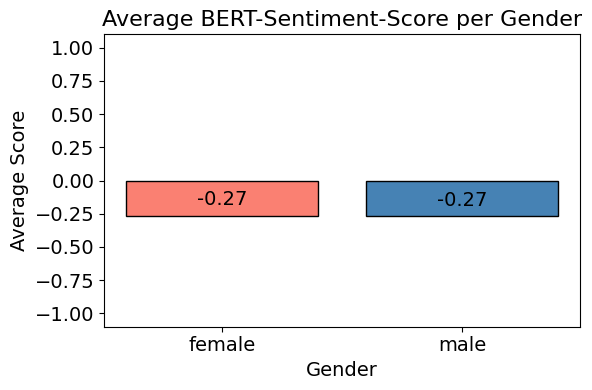

In [87]:
# Define gender colors
gender_colors = {
    'female': 'salmon',
    'male': 'steelblue'
}

# Compute mean and std per gender
agg = df.groupby('Gender')['Sentiment_Score_BERT'].agg(['mean']).reset_index()

# Plot mean sentiment score
plt.figure(figsize=(6, 4))
bars = plt.bar(
    x=agg['Gender'],
    height=agg['mean'],
    capsize=6,
    color=[gender_colors.get(g, 'gray') for g in agg['Gender']],
    edgecolor='black')

# Add Mean labels
for bar, value in zip(bars, agg['mean']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        value + 0.05,
        f"{value:.2f}",
        ha='center',
        va='bottom',
        fontsize=14)

plt.title("Average BERT-Sentiment-Score per Gender", fontsize=16)
plt.ylabel("Average Score", fontsize=14)
plt.xlabel("Gender", fontsize=14)
plt.ylim(-1.1, 1.1)
plt.xticks(rotation=0, fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

Note that -1 = negative, 0= neutral, 1= positive

Takeaway: Overall no difference in sentiment at all (in line with valence score from the Lexicon)

However, lets look at the sentiment differences between genders per topic

In [88]:
#Calculate average sentiment per topic and gender
sentiment_by_topic_gender = df.groupby(['Topic_Reduced', 'Gender'])['Sentiment_Score_BERT'].mean().reset_index()

#Pivot to wide format
sentiment_pivot = sentiment_by_topic_gender.pivot(index='Topic_Reduced', columns='Gender', values='Sentiment_Score_BERT').reset_index()
sentiment_pivot = sentiment_pivot.rename(columns={
    'female': 'Average_Sentiment_Female',
    'male': 'Average_Sentiment_Male'
})

#Calculate the difference (female - male)
sentiment_pivot['Sentiment_Difference'] = sentiment_pivot['Average_Sentiment_Female'] - sentiment_pivot['Average_Sentiment_Male']

#Merge with total speech counts
speech_counts_per_topic = df.groupby('Topic_Reduced').size().reset_index(name='Total_Speeches')
sentiment_merged = pd.merge(sentiment_pivot, speech_counts_per_topic, on='Topic_Reduced', how='left')

#Filter for topics with enough data
sentiment_filtered = sentiment_merged[sentiment_merged['Total_Speeches'] >= 100].copy()

#Sort by difference
sentiment_filtered_sorted = sentiment_filtered.sort_values(by='Sentiment_Difference', ascending=False)

Now we merge the table with the topic table from topic modeling section to get topic names

In [89]:
#Rename 'Topic ID' in topic_table_reduced_3 to match 'Topic_Reduced'
topic_table_reduced_3 = topic_table_reduced_3.rename(columns={
    'Topic ID': 'Topic_Reduced',
    'Topic Name': 'Topic_Name'})

#Merge on Topic_Reduced
sentiment_with_names = pd.merge(
    sentiment_filtered_sorted,
    topic_table_reduced_3[['Topic_Reduced', 'Topic_Name']],
    on='Topic_Reduced',
    how='left')

#Change order of columns
columns_order=['Topic_Name', 'Total_Speeches', 'Average_Sentiment_Female', 'Average_Sentiment_Male', 'Sentiment_Difference']

#Display the merged result
display(
    sentiment_with_names[columns_order].style.format({
        'Total_Speeches': '{:.0f}',
        'Average_Sentiment_Female': '{:.2f}',
        'Average_Sentiment_Male': '{:.2f}',
        'Sentiment_Difference': '{:.2f}'
    }).set_caption("Average BERT Sentiment by Topic and Gender with Topic Names"))

,Topic_Name,Total_Speeches,Average_Sentiment_Female,Average_Sentiment_Male,Sentiment_Difference
0,2_menschen_müssen_pandemie_pflege,487,-0.15,-0.31,0.16
1,3_kinder_familien_eltern_bildung,386,-0.21,-0.26,0.05
2,11_türkei_syrien_erdogan_irak,101,-0.21,-0.27,0.05
3,0_co2_klimaschutz_müssen_deutschland,796,-0.25,-0.30,0.05
4,-1_menschen_heute_bundestag_ja,3294,-0.29,-0.27,-0.02
5,1_schon_antrag_ja_bundestag,697,-0.39,-0.36,-0.03
6,5_bundeswehr_soldaten_mali_soldatinnen,259,-0.17,-0.13,-0.05
7,8_israel_deutschland_antisemitismus_juden,222,-0.37,-0.31,-0.06
8,7_rente_menschen_mindestlohn_grundrente,235,-0.33,-0.26,-0.07
9,6_digitalisierung_digitale_digitalen_daten,241,-0.23,-0.17,-0.07


No we want to vizualise both the topics

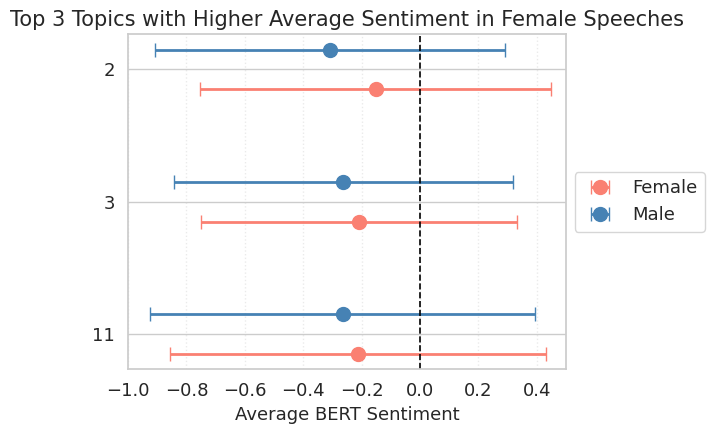

In [90]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Set clean Seaborn style
sns.set(style='whitegrid')

# Compute standard deviations per gender
sentiment_with_names['Std_Sentiment_Female'] = df.groupby(['Topic_Reduced', 'Gender'])['Sentiment_Score_BERT'].std().unstack()['female'].reset_index(drop=True)
sentiment_with_names['Std_Sentiment_Male'] = df.groupby(['Topic_Reduced', 'Gender'])['Sentiment_Score_BERT'].std().unstack()['male'].reset_index(drop=True)

# Select top 3 topics by sentiment difference
top3 = sentiment_with_names.sort_values('Sentiment_Difference', ascending=False).head(3)

def plot_sentiment(df_slice, title):
    fig, ax = plt.subplots(figsize=(6.5, 4.5))
    y = np.arange(len(df_slice))

    # Plot only error bars and dots (no text)
    ax.errorbar(df_slice['Average_Sentiment_Female'], y + 0.15,
                xerr=df_slice['Std_Sentiment_Female'], fmt='o',
                color='salmon', label='Female', capsize=5,
                markersize=10, elinewidth=2)
    ax.errorbar(df_slice['Average_Sentiment_Male'], y - 0.15,
                xerr=df_slice['Std_Sentiment_Male'], fmt='o',
                color='steelblue', label='Male', capsize=5,
                markersize=10, elinewidth=2)

    # Axis and formatting
    ax.axvline(0, linestyle='--', color='black', linewidth=1.2)
    ax.set_yticks(y)
    ax.set_yticklabels(df_slice['Topic_Reduced'], fontsize=13)
    ax.invert_yaxis()
    ax.set_xlabel("Average BERT Sentiment", fontsize=13)
    ax.set_title(title, fontsize=15)
    ax.grid(True, axis='x', linestyle=':', alpha=0.4)
    ax.tick_params(axis='x', labelsize=13)
    ax.set_xlim(-1.0, 0.5)

    # Legend
    ax.legend(title='', fontsize=13, loc='center left',
              bbox_to_anchor=(1.02, 0.5), borderaxespad=0)

    plt.tight_layout()
    plt.show()

# Plot Top 3 with clean bands only
plot_sentiment(top3, "Top 3 Topics with Higher Average Sentiment in Female Speeches")

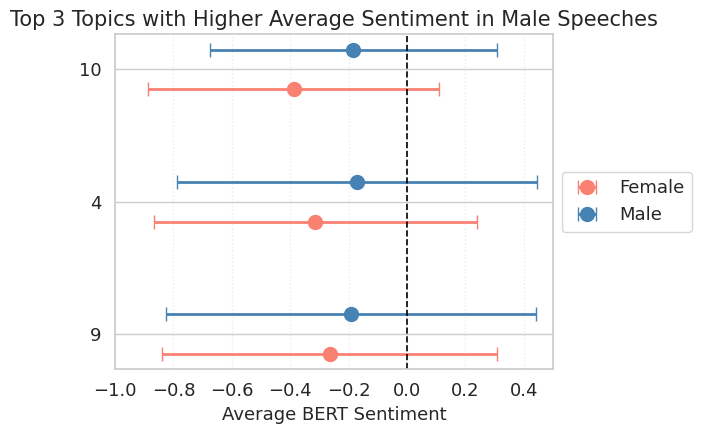

In [91]:
# Compute standard deviations per gender
sentiment_with_names['Std_Sentiment_Female'] = df.groupby(['Topic_Reduced', 'Gender'])['Sentiment_Score_BERT'].std().unstack()['female'].reset_index(drop=True)
sentiment_with_names['Std_Sentiment_Male'] = df.groupby(['Topic_Reduced', 'Gender'])['Sentiment_Score_BERT'].std().unstack()['male'].reset_index(drop=True)

# Select top 3 topics by sentiment difference
top3 = sentiment_with_names.sort_values('Sentiment_Difference', ascending=True).head(3)

def plot_sentiment(df_slice, title):
    fig, ax = plt.subplots(figsize=(6.5, 4.5))
    y = np.arange(len(df_slice))

    # Plot only error bars and dots (no text)
    ax.errorbar(df_slice['Average_Sentiment_Female'], y + 0.15,
                xerr=df_slice['Std_Sentiment_Female'], fmt='o',
                color='salmon', label='Female', capsize=5,
                markersize=10, elinewidth=2)
    ax.errorbar(df_slice['Average_Sentiment_Male'], y - 0.15,
                xerr=df_slice['Std_Sentiment_Male'], fmt='o',
                color='steelblue', label='Male', capsize=5,
                markersize=10, elinewidth=2)

    # Axis and formatting
    ax.axvline(0, linestyle='--', color='black', linewidth=1.2)
    ax.set_yticks(y)
    ax.set_yticklabels(df_slice['Topic_Reduced'], fontsize=13)
    ax.invert_yaxis()
    ax.set_xlabel("Average BERT Sentiment", fontsize=13)
    ax.set_title(title, fontsize=15)
    ax.grid(True, axis='x', linestyle=':', alpha=0.4)
    ax.tick_params(axis='x', labelsize=13)
    ax.set_xlim(-1.0, 0.5)

    # Legend
    ax.legend(title='', fontsize=13, loc='center left',
              bbox_to_anchor=(1.02, 0.5), borderaxespad=0)

    plt.tight_layout()
    plt.show()

# Plot Top 3 with clean bands only
plot_sentiment(top3, "Top 3 Topics with Higher Average Sentiment in Male Speeches")

# Classification

## Vectorization

In [92]:
#TF-IDF Vectorization
vectorizer=TfidfVectorizer(max_features=1000, max_df=0.8)
X = vectorizer.fit_transform(df['Speech_cleaned']).toarray()
y=df['Gender'].tolist()

In [93]:
#Convert X into list. of dicts for nltk processing
feature_names = vectorizer.get_feature_names_out()
X_dicts=[dict(zip(feature_names, vec)) for vec in X]

In [94]:
data = list(zip(X_dicts, y))

## Classification Naive Bayes - sklearn

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [96]:
clf = MultinomialNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      female       0.60      0.57      0.59      1002
        male       0.59      0.63      0.61       998

    accuracy                           0.60      2000
   macro avg       0.60      0.60      0.60      2000
weighted avg       0.60      0.60      0.60      2000



To get a better understanding of which words play an important role for classification, we retrieve the most important features by extracting the log probability

In [97]:
def show_nb_informative_features(vectorizer, model, class_labels, n=30):
    feature_names = vectorizer.get_feature_names_out()
    log_prob = model.feature_log_prob_
    diff = log_prob[1] - log_prob[0]

    topn = np.argsort(np.abs(diff))[-n:]

    print(f"{'Feature':<20} {class_labels[0]} <--> {class_labels[1]}")
    for i in reversed(topn):
        direction = class_labels[1] if diff[i] > 0 else class_labels[0]
        print(f"{feature_names[i]:<20} → {direction:<10} | Δ log prob: {diff[i]:.4f}")

In [98]:
model = MultinomialNB()
model.fit(X_train, y_train)

show_nb_informative_features(vectorizer, model, model.classes_, n=10)

Feature              female <--> male
pflege               → female     | Δ log prob: -1.0533
gewalt               → female     | Δ log prob: -0.8871
verehrt              → male       | Δ log prob: 0.8344
behinderung          → female     | Δ log prob: -0.8255
impfstoff            → female     | Δ log prob: -0.8165
israel               → male       | Δ log prob: 0.7490
jemand               → male       | Δ log prob: 0.7482
mann                 → female     | Δ log prob: -0.6862
zeichen              → male       | Δ log prob: 0.6521
ausbildung           → female     | Δ log prob: -0.6435


Highly interesting: We observe that the output from show_nb_informative_features, which highlights the most informative features for the Naive Bayes classifier, closely aligns with the dominant gendered topics identified through topic modeling. For example, features like “gewalt”, “pflege”, and “behinderung” are associated with female speeches and reflect social issues—mirroring the topics on gender equality, family, and caregiving. In contrast, male-associated features such as “verfassung” and “marktwirtschaft” correspond well with male-dominated topics related to constitutional and economic matters.

## MLP Classifier

basic mlp classifier, can still be tuned, inspired by Lab 9

In [99]:
model2 = MLPClassifier(
    hidden_layer_sizes=(100,),  # One hidden layer with 100 neurons
    activation='relu',
    solver='adam',
    max_iter=300,
    random_state=42
)

model2.fit(X_train, y_train)

MLPClassifier(max_iter=300, random_state=42)

In [100]:
y_pred2 = model2.predict(X_test)
print(classification_report(y_test, y_pred2))

              precision    recall  f1-score   support

      female       0.58      0.57      0.58      1002
        male       0.57      0.58      0.58       998

    accuracy                           0.58      2000
   macro avg       0.58      0.58      0.58      2000
weighted avg       0.58      0.58      0.58      2000



## BERT Classifier

In [101]:
tokenizer = BertTokenizer.from_pretrained('bert-base-german-cased')

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/255k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/485k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

In [102]:
#Encode labels (e.g., weiblich = 0, männlich = 1)
label_encoder = LabelEncoder()
df['gender_num'] = label_encoder.fit_transform(df['Gender'])

#Rename for Hugging Face compatibility
df_BERT = Dataset.from_pandas(df[['Speech', 'gender_num']].rename(columns={'Speech': 'text'}))

#Train-test split
df_BERT = df_BERT.train_test_split(test_size=0.2, seed=42)

In [103]:
#Tokenize Speech text column
def tokenize(example):
    tokens = tokenizer(example['text'], padding='max_length', truncation=True)
    tokens["labels"] = example["gender_num"]
    return tokens

In [104]:
#Create tokenized datset for BERT classification incl. tokenized text and gender
tokenized_dataset = df_BERT.map(
    tokenize,
    batched=True,
    remove_columns=['text', 'gender_num'])

Map:   0%|          | 0/6400 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

In [105]:
#Initialize Classification model
model3 = BertForSequenceClassification.from_pretrained('bert-base-german-cased', num_labels=2)

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-german-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [106]:
#Set training configuration
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none"
)
#Set up training loop
trainer = Trainer(
    model=model3,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
)
#Start training process
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.698500,0.663092
2,0.614400,0.640893


TrainOutput(global_step=1600, training_loss=0.656467227935791, metrics={'train_runtime': 302.8529, 'train_samples_per_second': 42.265, 'train_steps_per_second': 5.283, 'total_flos': 3367821508608000.0, 'train_loss': 0.656467227935791, 'epoch': 2.0})

In [107]:
#Predict test labels and display performance
preds = trainer.predict(tokenized_dataset["test"])
y_pred3 = preds.predictions.argmax(axis=1)
y_true = tokenized_dataset["test"]['labels']

print(classification_report(y_true, y_pred3, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

      female       0.66      0.64      0.65       818
        male       0.64      0.66      0.65       782

    accuracy                           0.65      1600
   macro avg       0.65      0.65      0.65      1600
weighted avg       0.65      0.65      0.65      1600

